<a href="https://colab.research.google.com/github/ygi0427/Course/blob/main/areoplanechess_fin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

#This part (game model and stack_planes_first strategy)refers to @yifanbao (github)#
COLOR = ['yellow', 'green', 'red', 'blue']

class Plane:
    __all_pieces = []
    __entering_location = {'yellow': 0, 'green': 13, 'red': 26, 'blue': 39}

    def __init__(self, color, no, location='hangar'):
        self.color = color
        self.no = no
        self.location = location
        self.location_color = color
        self.distance_travelled = 0
        Plane.__all_pieces.append(self)

    @staticmethod
    def clear_board():
        # Delete all the planes
        while len(Plane.__all_pieces):
            piece = Plane.__all_pieces.pop(0)
            del piece

    def update_location(self):
        # Uupdate the location of plane when it moves
        previous_location = self.location
        if self.location == 'hangar':
            self.location = 'standby'
        elif self.location == 'standby' or isinstance(self.location, int):
            if self.distance_travelled <= 50:  # Still in the track
                entering_location = Plane.__entering_location[self.color]
                self.location = entering_location + self.distance_travelled
                if self.location >= 52:
                    self.location -= 52
                self.location_color = COLOR[self.location % 4 - 1]
            elif self.distance_travelled <= 55:  # Entering into home zone
                self.location = 'home zone'
                self.location_color = self.color
            else:  # Arrived in the center
                self.location = 'settled'
        elif self.location == 'home zone':
            if self.distance_travelled >= 56:
                self.location = 'settled'
        elif self.location == 'settled':
            raise ValueError('Should not update the location of a settled plane!')

    def standby(self):
        # Get the plane from hangar to standby
        if self.location != 'hangar':
            raise ValueError('Plane has already entered!')
        else:
            self.location = 'standby'

    def move(self, distance: int, enable_jump=True):
        # Check if there are planes stacked
        stacked_planes = self.get_planes_stacked()

        # Move the plane
        self.distance_travelled += distance
        self.update_location()

        if isinstance(self.location, int):
            # When landing on an opponent's piece, send back that piece to its hangar
            self.send_back_plane_against()

            # When landing on the entrance of the plane color's shortcut, jump to the exit
            if self.distance_travelled == 18:
                self.move(12, False)
            elif enable_jump:
                # When landing on a space of the plane's own color, jump to the next space of that color
                if self.color == self.location_color:
                    self.move(4, False)

        # Move planes in the same stack
        if len(stacked_planes):
            for plane in stacked_planes:
                plane.distance_travelled = self.distance_travelled
                plane.location = self.location
                plane.location_color = self.location_color

    def send_back_plane_against(self):
        for plane in Plane.__all_pieces:
            if plane.location == self.location and plane.color != self.color:
                plane.send_back()

    def send_back(self):
        self.location = 'hangar'
        self.location_color = self.color
        self.distance_travelled = 0

    def can_stack_after(self, distance):
        # Find out whether this plane can stack with other planes after moving
        if isinstance(self.location, int):
            for plane in Plane.__all_pieces:
                if isinstance(plane.location, int):
                    if self.location + distance == plane.location and self.color == plane.color:
                        return True
        return False

    def get_planes_stacked(self):
        stack = []
        if self.distance_travelled > 0:
            for plane in Plane.__all_pieces:
                if self.distance_travelled == plane.distance_travelled and self.color == plane.color:
                    stack.append(plane)
        return stack


class Player:
    players = []

    def __init__(self, color, name, strategy=None, max_planes_on_track=4, q_table=None, lambda_=0.9):
        # Initialize players
        self.color = color
        self.name = name
        self.moving_planes = []
        self.settled_planes = []
        self.strategy = strategy
        self.max_planes_on_track = max_planes_on_track
        self.q_table = q_table if q_table is not None else defaultdict(lambda: [0.0] * 4)
        self.lambda_ = lambda_
        self.eligibility_trace = defaultdict(lambda: [0.0] * 4)
        Player.players.append(self)
        self.setup_planes()

    @staticmethod
    def clear_player():
        # Delete all the players
        while len(Player.players):
            player = Player.players.pop(0)
            del player

    @staticmethod
    def setup_players(number=4):
        if not 2 <= number <= 4:
            raise ValueError('Only 2-4 players are allowed!')
        else:
            for n in range(number):
                Player(COLOR[n], COLOR[n].capitalize())

    def setup_planes(self):
        self.moving_planes = [Plane(self.color, f'p{n+1}') for n in range(4)]

    def move_plane(self):
        dice = random.randint(1, 6)
        awaiting_planes = []
        available_planes = []
        if dice == 6:
            for plane in self.moving_planes:
                if plane.location == 'hangar':
                    awaiting_planes.append(plane)
            if len(awaiting_planes):
                selected_plane = random.choice(awaiting_planes)
                selected_plane.standby()
            else:
                available_planes = self.moving_planes
                selected_plane = self.select_plane_by_strategy(dice, available_planes)
                selected_plane.move(6)
                if selected_plane.location == 'settled':
                    stacked_planes = selected_plane.get_planes_stacked()
                    self.settle(selected_plane.no)
                    if len(stacked_planes):
                        for plane in stacked_planes:
                            self.settle(plane.no)
            if not self.is_winner():
                self.move_plane()
        else:
            for plane in self.moving_planes:
                if plane.location != 'hangar':
                    available_planes.append(plane)
            if len(available_planes):
                selected_plane = self.select_plane_by_strategy(dice, available_planes)
                selected_plane.move(dice)
                if selected_plane.location == 'settled':
                    stacked_planes = selected_plane.get_planes_stacked()
                    self.settle(selected_plane.no)
                    if len(stacked_planes):
                        for plane in stacked_planes:
                            self.settle(plane.no)

    def select_plane_by_strategy(self, dice, available_planes):
        if self.strategy == 'q_learning':
            return self.select_plane_q_learning(dice, available_planes)
        elif self.strategy == 'td_lambda':
            return self.select_plane_td_lambda(dice, available_planes)
        elif self.strategy == 'stack_planes_first':
            stackable_planes = []
            for plane in available_planes:
                if plane.can_stack_after(dice):
                    stackable_planes.append(plane)
            if len(stackable_planes):
                return random.choice(stackable_planes)
            else:
                return random.choice(available_planes)
        else:
            return random.choice(available_planes)

    def select_plane_q_learning(self, dice, available_planes):
        state = self.get_state_representation()
        state_index = self.hash_state(state)
        actions = [plane.no for plane in available_planes]
        if not actions:
            return random.choice(available_planes)
        action_values = [self.q_table[state_index][self.hash_action(action)] for action in actions]
        best_action = actions[np.argmax(action_values)]
        for plane in available_planes:
            if plane.no == best_action:
                return plane

    def select_plane_td_lambda(self, dice, available_planes):
        state = self.get_state_representation()
        state_index = self.hash_state(state)
        actions = [plane.no for plane in available_planes]
        if not actions:
            return random.choice(available_planes)
        action_values = [self.q_table[state_index][self.hash_action(action)] for action in actions]
        best_action = actions[np.argmax(action_values)]
        for plane in available_planes:
            if plane.no == best_action:
                return plane

    def update_q_table(self, previous_state, action, reward, next_state, alpha=0.1, gamma=0.9):
        previous_index = self.hash_state(previous_state)
        next_index = self.hash_state(next_state)
        action_index = self.hash_action(action)
        best_next_action_value = max(self.q_table[next_index])
        td_target = reward + gamma * best_next_action_value
        td_error = td_target - self.q_table[previous_index][action_index]
        self.q_table[previous_index][action_index] += alpha * td_error

    def update_td_lambda(self, previous_state, action, reward, next_state, alpha=0.1, gamma=0.9):
        previous_index = self.hash_state(previous_state)
        next_index = self.hash_state(next_state)
        action_index = self.hash_action(action)
        best_next_action_value = max(self.q_table[next_index])
        td_target = reward + gamma * best_next_action_value
        td_error = td_target - self.q_table[previous_index][action_index]
        self.eligibility_trace[previous_index][action_index] += 1

        for state_index in self.q_table.keys():
            for action_index in range(4):
                self.q_table[state_index][action_index] += alpha * td_error * self.eligibility_trace[state_index][action_index]
                self.eligibility_trace[state_index][action_index] *= gamma * self.lambda_

    def settle(self, p_no):
        for idx in range(len(self.moving_planes)):
            if self.moving_planes[idx].no == p_no:
                settled_plane = self.moving_planes.pop(idx)
                self.settled_planes.append(settled_plane)
                settled_plane.distance_travelled = -1
                break

    def is_winner(self):
        if len(self.moving_planes):
            return None
        else:
            return self.name

    def get_state_representation(self):
        state = []
        for plane in self.moving_planes:
            state.append((plane.color, plane.location, plane.distance_travelled))
        return tuple(state)

    def hash_state(self, state):
        return hash(state) % 1000

    def hash_action(self, action):
        return int(action[-1]) - 1


Player 3 won 2500 times.
Player 4 won 2341 times.
Player 1 won 2658 times.
Player 2 won 2501 times.
Player 3 win percentage: 25.00%
Player 4 win percentage: 23.41%
Player 1 win percentage: 26.58%
Player 2 win percentage: 25.01%


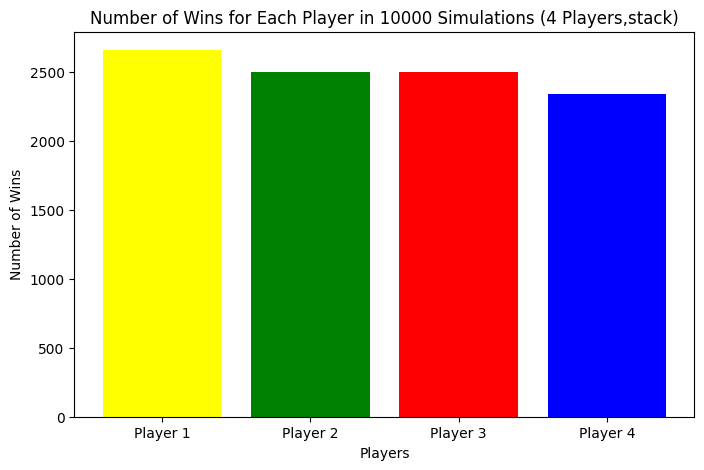

In [ ]:
### ALL stacked ###
def simulate_single_game(players):
    # Clear existing planes
    Plane.clear_board()

    for player in players:
        player.setup_planes()

    while True:
        for player in players:
            if not player.moving_planes:
                continue  # Skip if no moving planes
            player.move_plane()

            if player.is_winner():
                return player.name

def simulate_multiple_games(num_games):
    # Clear any existing players
    Player.clear_player()

    # Create players with 'stack_planes_first' strategy
    player1 = Player('yellow', 'Player 1', strategy='stack_planes_first')
    player2 = Player('green', 'Player 2', strategy='stack_planes_first')
    player3 = Player('red', 'Player 3', strategy='stack_planes_first')
    player4 = Player('blue', 'Player 4', strategy='stack_planes_first')

    players2 = [player1, player2]
    players3 = [player1, player2, player3]
    players4 = [player1, player2, player3, player4]

    results = defaultdict(int)

    for _ in range(num_games):
        winner = simulate_single_game(players4) #####number of players#####
        results[winner] += 1

    return results

# Simulate
num_games = 10000
results = simulate_multiple_games(num_games)

# Print the results
for player, wins in results.items():
    print(f'{player} won {wins} times.')

for player, wins in results.items():
    print(f'{player} win percentage: {wins / num_games * 100:.2f}%')

# Visualization
def visualize_results(results, num_players=4, num_games=10000):
    player_order = ['Player 1', 'Player 2', 'Player 3', 'Player 4']
    colors = ['yellow', 'green', 'red', 'blue']
    wins = [results.get(player, 0) for player in player_order[:num_players]]

    plt.figure(figsize=(8, 5))
    plt.bar(player_order[:num_players], wins, color=colors[:num_players])
    plt.xlabel('Players')
    plt.ylabel('Number of Wins')
    plt.title(f'Number of Wins for Each Player in {num_games} Simulations ({num_players} Players,stack)')
    plt.show()

visualize_results(results)


Player 2 won 2701 times.
Player 1 won 2243 times.
Player 4 won 2522 times.
Player 3 won 2534 times.
Player 2 win percentage: 27.01%
Player 1 win percentage: 22.43%
Player 4 win percentage: 25.22%
Player 3 win percentage: 25.34%


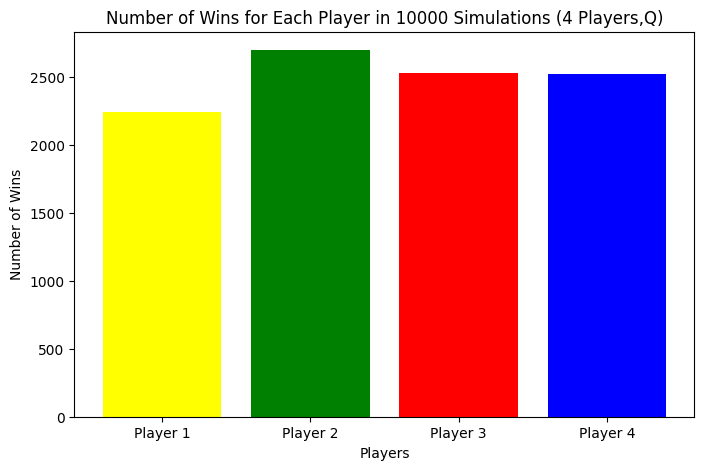

In [ ]:
####Q#####

def simulate_single_game_q(players, q_table, alpha, gamma):
    # Clear existing planes
    Plane.clear_board()

    for player in players:
        player.setup_planes()
        if player.strategy == 'q_learning':
            player.q_table = q_table

    while True:
        for player in players:
            previous_state = player.get_state_representation()
            if not player.moving_planes:
                continue  # Skip if no moving planes
            player.move_plane()
            next_state = player.get_state_representation()
            reward = 1 if player.is_winner() else 0

            if player.strategy == 'q_learning' and player.moving_planes:
                if player.moving_planes:
                    selected_plane = player.select_plane_q_learning(0, player.moving_planes)
                    player.update_q_table(previous_state, selected_plane.no, reward, next_state, alpha, gamma)

            if player.is_winner():
                return player.name
def simulate_multiple_games_q(num_games):
    # Clear any existing players
    Player.clear_player()

    # Create players
    player1q = Player('yellow', 'Player 1', strategy='q_learning')
    player2 = Player('green', 'Player 2', strategy='stack_planes_first')
    player3 = Player('red', 'Player 3', strategy='stack_planes_first')
    player4 = Player('blue', 'Player 4', strategy='stack_planes_first')

    players2_q = [player1q, player2]
    players3_q = [player1q, player2, player3]
    players4_q = [player1q, player2, player3, player4]

    # Initialize Q-learning parameters
    q_table = defaultdict(lambda: [0.0] * 4)
    alpha = 0.1  # Learning rate
    gamma = 0.9  # Discount factor

    results = defaultdict(int)

    for _ in range(num_games):
        winner = simulate_single_game_q(players4_q, q_table, alpha, gamma) #####number of players#####
        results[winner] += 1

    return results

# Simulate
num_games = 10000
results = simulate_multiple_games_q(num_games)

# Print the results
for player, wins in results.items():
    print(f'{player} won {wins} times.')

for player, wins in results.items():
    print(f'{player} win percentage: {wins / num_games * 100:.2f}%')

# Visualization
def visualize_results(results, num_players=4, num_games=10000):
    player_order = ['Player 1', 'Player 2', 'Player 3', 'Player 4']
    colors = ['yellow', 'green', 'red', 'blue']
    wins = [results.get(player, 0) for player in player_order[:num_players]]

    plt.figure(figsize=(8, 5))
    plt.bar(player_order[:num_players], wins, color=colors[:num_players])
    plt.xlabel('Players')
    plt.ylabel('Number of Wins')
    plt.title(f'Number of Wins for Each Player in {num_games} Simulations ({num_players} Players,Q)')
    plt.show()

visualize_results(results)


Player 4 won 2435 times.
Player 3 won 2636 times.
Player 1 won 2293 times.
Player 2 won 2636 times.
Player 4 win percentage: 24.35%
Player 3 win percentage: 26.36%
Player 1 win percentage: 22.93%
Player 2 win percentage: 26.36%


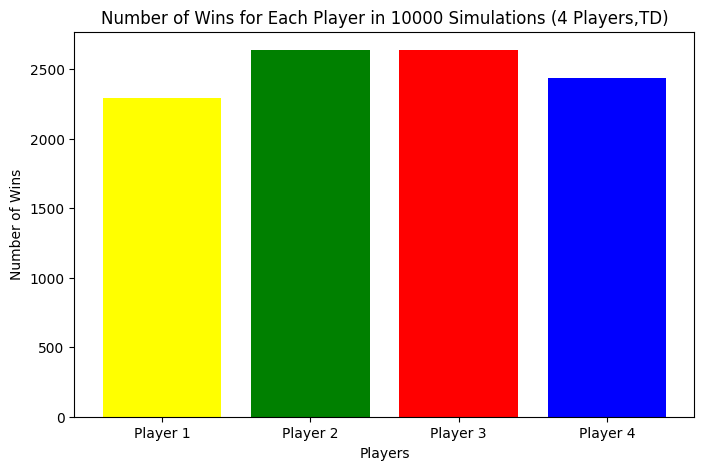

In [ ]:
####TD#####
def simulate_single_game_td(players, q_table, alpha, gamma, lambda_):
    # Clear existing planes
    Plane.clear_board()

    for player in players:
        player.setup_planes()
        if player.strategy == 'td_lambda':
            player.q_table = q_table
            player.eligibility_trace = defaultdict(lambda: [0.0] * 4)

    while True:
        for player in players:
            previous_state = player.get_state_representation()
            if not player.moving_planes:
                continue  # Skip if no moving planes
            player.move_plane()
            next_state = player.get_state_representation()
            reward = 1 if player.is_winner() else 0

            if player.strategy == 'td_lambda' and player.moving_planes:
                selected_plane = player.select_plane_td_lambda(0, player.moving_planes)
                player.update_td_lambda(previous_state, selected_plane.no, reward, next_state, alpha, gamma)

            if player.is_winner():
                return player.name

def simulate_multiple_games_td(num_games):
    # Clear any existing players
    Player.clear_player()

    # Create players
    player1td = Player('yellow', 'Player 1', strategy='td_lambda', lambda_=0.9)
    player2 = Player('green', 'Player 2', strategy='stack_planes_first')
    player3 = Player('red', 'Player 3', strategy='stack_planes_first')
    player4 = Player('blue', 'Player 4', strategy='stack_planes_first')

    players2_td = [player1td, player2]
    players3_td = [player1td, player2, player3]
    players4_td = [player1td, player2, player3, player4]

    # Initialize TD(λ) parameters
    q_table = defaultdict(lambda: [0.0] * 4)
    lambda_ = 0.9  # Decay rate for eligibility traces
    alpha = 0.1  # Learning rate
    gamma = 0.9  # Discount factor

    results = defaultdict(int)

    for _ in range(num_games):
        winner = simulate_single_game_td(players4_td, q_table, alpha, gamma, lambda_)#####number of players#####
        results[winner] += 1

    return results

# Simulate
num_games = 10000
results = simulate_multiple_games_td(num_games)

# Print the results
for player, wins in results.items():
    print(f'{player} won {wins} times.')

for player, wins in results.items():
    print(f'{player} win percentage: {wins / num_games * 100:.2f}%')

# Visualization
def visualize_results(results, num_players=4, num_games=10000):
    player_order = ['Player 1', 'Player 2', 'Player 3', 'Player 4']
    colors = ['yellow', 'green', 'red', 'blue']
    wins = [results.get(player, 0) for player in player_order[:num_players]]

    plt.figure(figsize=(8, 5))
    plt.bar(player_order[:num_players], wins, color=colors[:num_players])
    plt.xlabel('Players')
    plt.ylabel('Number of Wins')
    plt.title(f'Number of Wins for Each Player in {num_games} Simulations ({num_players} Players,TD)')
    plt.show()

visualize_results(results)

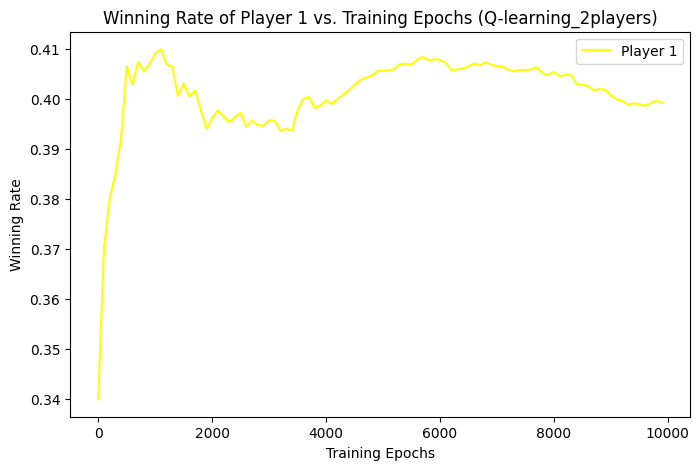

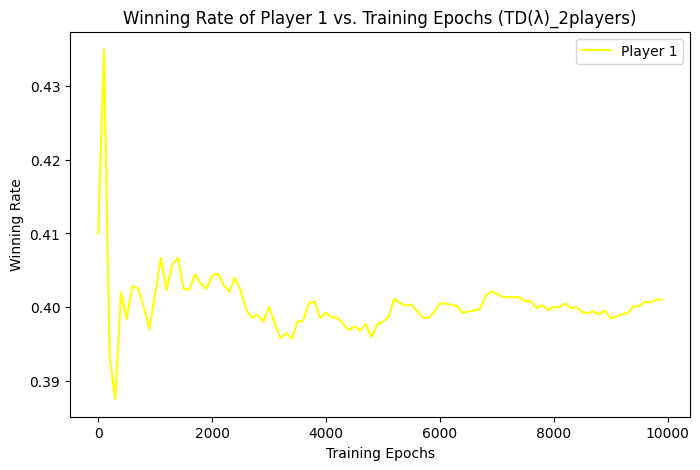

In [ ]:

def simulate_single_game(players):
    Plane.clear_board()

    for player in players:
        player.setup_planes()

    while True:
        for player in players:
            if not player.moving_planes:
                continue  # Skip if no moving planes
            player.move_plane()

            if player.is_winner():
                return player.name

def simulate_and_track_winning_rates(num_games, strategy, batch_size):
    Player.clear_player()

    player1 = Player(COLOR[0], 'Player 1', strategy=strategy)
    player2 = Player(COLOR[1], 'Player 2', strategy='stack_planes_first')
    player3 = Player(COLOR[2], 'Player 3', strategy='stack_planes_first')
    player4 = Player(COLOR[3], 'Player 4', strategy='stack_planes_first')

    players4 = [player1, player2, player3, player4]
    players3 = [player1, player2, player3]
    players2 = [player1, player2]

    q_table = defaultdict(lambda: [0.0] * 4)
    lambda_ = 0.9  # Decay rate for eligibility traces
    alpha = 0.1  # Learning rate
    gamma = 0.9  # Discount factor

    results = defaultdict(int)
    winning_rates = []

    for batch_start in range(0, num_games, batch_size):
        for _ in range(batch_size):
            winner = simulate_single_game(players2) ######NUM#######
            results[winner] += 1

        # Calculate winning rate for Player 1
        total_games_played = batch_start + batch_size
        player1_wins = results['Player 1']
        winning_rate = player1_wins / total_games_played
        winning_rates.append(winning_rate)

    return winning_rates

def visualize_winning_rates(winning_rates, num_games, strategy):
    epochs = range(0, num_games, len(winning_rates))

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, winning_rates, label='Player 1', color='yellow')
    plt.xlabel('Training Epochs')
    plt.ylabel('Winning Rate')
    plt.title(f'Winning Rate of Player 1 vs. Training Epochs ({strategy})')
    plt.legend()
    plt.show()

# Simulate and visualize results for Q-learning and TD(λ)
num_games = 10000
batch_size = 100

# Q-learning simulation
winning_rates_q = simulate_and_track_winning_rates(num_games, 'q_learning', batch_size)
visualize_winning_rates(winning_rates_q, num_games, 'Q-learning_2players')

# TD(λ) simulation
winning_rates_td = simulate_and_track_winning_rates(num_games, 'td_lambda', batch_size)
visualize_winning_rates(winning_rates_td, num_games, 'TD(λ)_2players')